# **Project**: _'Retrieving Companies' Contact Information'_
<br><br>

## &#128210; **_Scenario_**
&emsp; The boss of a Greek tech company wants to expand his business to include the Greek defence industry as potential customers or cooperatives. For this reason, he asked the data engineering dept to gather contact information of the defence and security companies located in Greece and pass this information to the public relations dept for further usage.
<br><br>

## &#127760; **_Scope_**
&emsp; The scope of this mini-project narrows to Greek territory.
<br><br>

## &#127919; **_Objective_**
&emsp; The data engineering dept's objective is to gather adequate contact information for the Greek companies involved in the defence industry.
<br><br>

## &#128270; **_Course-of-Action_**
&emsp; As a data engineer, I should answer the following questions:
- What contact information should I gather?
- Where can I find this information?
- How to retrieve the information we need?
- Where to store this information?
<br><br>

&emsp; To begin with, the data engineering dept, cooperating with the public relations dept, concluded that the information to be retrieved will be the `company's name`, `physical address`, `email address`, `phone number`, and their `official website address`. Apart from that, the public relations dept asked the data engineering dept to store this information in a database. Now, the data engineering dept knows what information to bring and where to store it.<br>

&emsp; But wait, where will the data engineering dept look up for such info? Yellow pages? (maybe, in some other Era 😆) Asking around? (It will take us ages to complete the task, plus a lot of sweat; overall, it's not efficient enough). We're living in 21<sup>st</sup> century for God's sake, Internet of course. Okay, we narrowed down our sources, but that also sounds like a lot of effort! 😆 Wait a minute, usually industries like that create Associations. Bingo! 🙌 God bless the internet, such an Association is listed in Greece, and this will be our [resource](https://sekpy.gr/ 'Hellenic Manufacturers of Defence Materiel Association')! There, we can find the information we need. Are all the companies involved in defense matters? Possibly not, but still there are a lot (over 200 companies listed).<br>

&emsp; Now, we need to figure out how to retrieve the information(?!) Hmmm... The data engineering dept has other projects running; the personnel cannot do that manually. Maybe an automated process could help. The Association's website shows two steps to get this information for every company listed. First, we need to select a specific company from the listed ones, which this link drives us to the company's contact info that we are interested in. Apart from that, the listed companies are loaded in pages (which will be a challenge, too). That being said, building an automation process will be a more effective way to move on. So, for the automated process (ETL), we will need to figure out :
- How to overcome the paging issue.
- How to overcome stuffing the server (with over 200 requests without being blocked 😆).
- How to locate the information we need on a webpage.

To overcome the paging issue, we need to understand how the URL of the website changes from page to page so that we can iterate through them.
To overcome stuffing the website's server we will send our requests in a random timeframe giving enough time from call to call.
We will locate the information we need using the inspection tool of our web browser.
Problem solved (hopefully 😆). There are other ways to proceed with these issues, but for simplicity we will stick to that.
<br><br>

&emsp; So far, so good. All we need to do now is turn our thoughts into action. Let's dive in!

In [33]:
import re
import random
import time
import datetime
from tqdm import tqdm
import os

import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import sqlite3

from IPython.display import Image

In [ ]:
main_url = 'https://sekpy.gr/en/member-companies/'

# _Extract_

During this stage we will:
- retrieve the pages' content
- retrieve the companies and their respective intra-url
- retrieve detailed info about each company

For this reason, we will create the following main functions:
- `retrieve_pages_content(...)`: this func will retrieve the content of each page.
- `get_company_entries(...)`: this func iterates through pages' content and creates a list of tuples containing the company's name and its respective intra-url.
- `get_company_details(...)`: this func iterates through companies and creates a list of tuples containing the company's detailed information (company's name, address, email, phone number, and website url).

Finally, the extracted information will be placed in a dataframe for further processing.

In [ ]:
def get_content(url):
  '''
    USAGE: this func retrieves the content of a page
    INPUT:
      url (string) - the url of the page
    OUTPUT:
      soup (bs4.BeautifulSoup) - the content of the page
  '''
  response = requests.get(url)

  if response:
    html_content = response.content

  soup = BeautifulSoup(html_content, 'html.parser')
  return soup

In [ ]:
def retrieve_pages_content(url):

  '''
    USAGE: this func will retrieve the content of each page
    TODO: 1. create a list to store the content of each page
          2. iterate through the number of pages (here there are 27)
          3. join the main URL with the page number (as a string)
          4. get the content of the current page
          5. add the content of each page to a list
    INPUT:
      url (string) - the url of the main page
    OUTPUT:
      contents (list) - a list containing the content of each page
  '''

  # creating a list to store the content of each page
  contents = []

  # iterating through the number of pages
  for page in tqdm(range(1,28), desc='Getting Pages Content...'):

    # the 1st page of the url doesn't contain any number, so I'll keep it empty
    if page == 1:
      page = ''

    # joining the main url with the page number (as a string; the func doesn't accept numeric values)
    path = os.path.join(url, str(page))

    # getting the content of the current page
    content = get_content(path)

    # add the content of each page to a list
    contents.append(content)

    # creating a random delay for each iteration for obvious reasons :)
    sleep_time = random.randint(5, 10)
    time.sleep(sleep_time)

  return contents

In [ ]:
def get_intra_url(page_content):
  '''
    USAGE: this func will retrieve the company name and its respective intra-url
            from a page content
    TODO: 1. get all the h2 tags from the page content
          2. iterate through the h2 tags
          3. get the company name and the intra-url from the tag
          4. update the pre_companies dictionary with the company name and the intra-url
    INPUT:
      tag (bs4.element.Tag-h2) - the tag containing the company name and the intra-url
    OUTPUT:
      companies (list) - the companies and their respective intra-urls as a tuple in a page
  '''
  # retrieve all the h2 tags of a page's content
  tags_h2 = page_content.find_all('h2')[1:-1]

  #>>>> getting page's companies
  companies = []

  # iterate each h2-tag to get company's name and intra-url
  for tag in tags_h2:

    company = tag.text.strip()
    company_url = tag.a.get('href')

    companies.append((company, company_url)) # adding each page's companies' info to a list

  return companies

In [ ]:
def get_company_entries(pages):
  '''
    USAGE:  this func iterates through the page's content and creates a list of tuples
            containing the company name and its respective intra-url
    INPUT:
      pages (list) - a list containing the content of each page
    OUTPUT:
      companies (list) - a list of tuples containing the company name and the intra-url
  '''
  companies = []

  for content in tqdm(pages, desc='Getting Company Entries...'):

    companies.extend(get_intra_url(content))

  return companies

In [ ]:
def get_details(company_entry):
  '''
    USAGE: the use of this func is to retrieve detailed information
            about a given company from its intra-url of the website
    TODO: 1. get the company's name and intra-url from the tuple
          2. retrieve the content of the specific intra-url
          3. retrieve the specific unordered list (ul) from the content containing
              the set of details we want to retrieve
          4. find all the items (li) of the unordered list
          5. get the detailed info we want from the company
    INPUT:
      company_entry (tuple) - a tuple containing the company name and the intra-url
    OUTPUT:
      company_name (string) - the company's name
      address (string) - the company's address
      email (string) - the company's email
      phone (string) - the company's phone number
      website (string) - the company's website
  '''

  # 1. get the company's name and intra-url from the tuple
  company = company_entry[0]
  url = company_entry[1]

  # 2. retrieve the content of the specific intra-url
  company_content = get_content(url)

  # 3. retrieve the specific unordered list (ul) from the content
  tags_ul = company_content.find_all('ul', class_='elementor-icon-list-items')[0]

  # 4. find all the items (li) of the unordered list
  tags_li = tags_ul.find_all('li')

  # 5. get the detailed info we want from the company
  company_name = company
  address = tags_li[2].text.split(':')[1].strip() if 'Address' in tags_li[2].text else np.nan
  email = tags_li[3].text.split(':')[1].strip() if 'Email' in tags_li[3].text else np.nan
  phone = tags_li[4].text.split(':')[1].strip() if 'Telephone' in tags_li[4].text else np.nan
  website = tags_li[5].text.strip() if tags_li[5].text else np.nan

  return company_name, address, email, phone, website

In [ ]:
def get_company_details(companies):
  '''
    USAGE:  this func iterates through companies and creates a list of tuples
            containing the company's detailed information
    INPUT:
      companies (list) - a list of tuples containing the company name and the intra-url
    OUTPUT:
      data (list) - a list of tuples containing the company's detailed information
  '''
  data = []

  for company in tqdm(companies, desc='Getting Detailed Data...'):

    # get the company's details
    company_name, address, email, phone, website = get_details(company)

    # add detailed info as a tuple to a list
    data.append((company_name, address, email, phone, website))

    # creating a random delay for each iteration for obvious reasons :)
    sleep_time = random.randint(5, 10)
    time.sleep(sleep_time)

  return data

In [ ]:
def extract_data(url):
  '''
    USAGE: this func extracts the companies' detail info from the website
    TODO: 1. retrieve the pages' content
          2. retrieve the companies and their respective intra-url
          3. retrieve detailed info about each company
    INPUT:
      url (string) - the url of the main page
    OUTPUT:
      df (pandas.DataFrame) - a dataframe containing the detailed info about each company
  '''

  contents = retrieve_pages_content(url)


  company_entries = get_company_entries(contents)


  data = get_company_details(company_entries)


  colmns=['company_name', 'address', 'email', 'phone_number', 'website']
  df = pd.DataFrame(data, columns=colmns)

  return df

In [ ]:
extracted_data = extract_data(main_url)

Getting Detailed Data...: 100%|██████████| 242/242 [40:14<00:00,  9.98s/it]


# _Transform_



In [188]:
extracted_data = pd.read_csv('hellenic_defense_associates.csv')

In [126]:
extracted_data.head(3)

,company_name,address,email,phone_number,website
0,ΠΑΠΑΓΕΩΡΓΙΟΥ WIRELAND ΟΕ,11km Thessaloniki-Athens (Sindos),info@wireland.gr,"+30 2310 795992, +30 2310 527742",https://wireland.gr/el/
1,3DHUB IKE,"Θεσσαλονίκης 129 & Άρτης 1, 18346 Μοσχάτο",info@3dhub.gr,2104636659,http://www.3dhub.gr/
2,Adamant Composites,"Agia Laura Street, Thesi Skamnies Ano Kastrits...",info@adamant-composites.com,2610931730,https://www.adamant-composites.com/


In [127]:
extracted_data.tail(3)

,company_name,address,email,phone_number,website
239,Πλάνετεκ Ελλάς Ε.Π.Ε.,"Λεωφόρος Κηφισίας 44 (Monumental Plaza, Κτήριο...",info@planetek.gr,+30 2152157390,www.planetek.gr
240,ΤΕΧΝΟΛΟΓΙΕΣ ΕΝΤΟΛΗΣ ΕΛΕΓΧΟΥ ΕΠΙΚΟΙΝΩΝΙΩΝ Α.Β.Ε.Ε.,"Kilkis Industrial Area, 611 00, Kilkis",c3t@the.forthnet.gr,2341071947,https://www.c3t.gr
241,Χ. & Δ. ΟΡΦΑΝΙΔΗΣ Α.Β.Ε.Ε.,Ιωνος Δραγούμη 26 - Ιωνία (Ν. Μαγνησία) Τ.Κ....,info@orfanidis.eu,2310 781265,www.orfanidis.eu


In [159]:
extracted_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  242 non-null    object
 1   address       242 non-null    object
 2   email         242 non-null    object
 3   phone_number  240 non-null    object
 4   website       233 non-null    object
dtypes: object(5)
memory usage: 9.6+ KB


We can see that we have a handfull of missing values. We found the phone number missing values, but it wasn't that successful with the websites, so we will leave it as it is for now and hopufully will fix that in the future.

In [189]:
# updating manually missing phone numbers

missing_phone_idx = extracted_data[extracted_data['phone_number'].isna()].index.to_list()

update_phones = ['2104833273', '2310717100']

extracted_data.loc[missing_phone_idx, 'phone_number'] = update_phones

In [190]:
extracted_data.isna().sum()

,0
company_name,0
address,0
email,0
phone_number,0
website,9


In [191]:
def transform_website(website):
  '''
    USAGE: this func fixes the websites' addresses in our favour (http(s)://...) if any
            If no website address, then NaN
  '''
  if pd.isnull(website):
    return np.nan

  if 'Twitter' in website:
    website = re.sub('Twitter$', '', website).strip()

  if '&' in website:
    web_parts = website.split('&')
    website = 'https://' + web_parts[0].strip()

  if re.search('http://|https://', website):
    website = website
  elif website == '(-)':
    website = np.nan
  elif re.search('^www', website):
    website = 'https://' + website
  elif website.startswith('http'):
    website = 'https://' + website[website.find('//')+2:]
  else:
    website = 'https://' + website

  return website

In [192]:
extracted_data['website'] = extracted_data['website'].apply(transform_website)

In [193]:
extracted_data.website.to_list()

['https://wireland.gr/el/',
 'http://www.3dhub.gr/',
 'https://www.adamant-composites.com/',
 'https://www.aet.gr/',
 'https://www.aeroservices.gr/',
 'https://akmonsa.gr/',
 'http://www.alave.gr/',
 'https://alexmolds.gr/',
 'http://www.alkyonis.co/',
 'https://alphasys.gr/',
 'https://www.althom.de/',
 'https://altus-lsa.com/',
 'https://www.aluman.gr/',
 'http://www.amplus.gr/',
 'https://amsaero.eu/',
 'https://anateco.gr/',
 'https://www.anima.eu/',
 'https://www.anorak.gr',
 'https://apella.gr/',
 'https://www.ariexpo.gr/',
 'https://arpedon.com/',
 'https://www.asd-sa.gr/',
 'https://www.atc.gr',
 'https://www.atcor.com.gr/',
 'https://www.aviatec.gr',
 'https://www.avs.gr/#page_0/',
 'https://www.axoneng.gr',
 'https://www.btcomposites.gr',
 'https://www.barracuda.gr',
 'https://www.bellowshellas.com/',
 'https://www.bgi-europe.com',
 'https://www.vimkaepe.gr',
 'https://www.bima.gr',
 'https://www.bmte.gr',
 'https://www.by-linear.com/',
 nan,
 'https://www.kassidiaris.gr/',
 

Problem solved. Let's fix the phone numbers...

In [194]:
extracted_data['phone_number'].to_list()

['+30 2310 795992,  +30 2310 527742',
 '2104636659',
 '2610931730',
 '2110176456',
 '2106844633',
 '2106773480-1e',
 '2108941990',
 '2104117250',
 '210 8982367',
 '2107214777',
 '2610333816',
 '2821044492',
 '2103609435',
 '210 6100020',
 '211 0168511 / 2103541235',
 '2102824050-1',
 '+302107776822',
 '2102029338',
 '2106635528 / +30 6937 318351',
 '2109843863',
 '210 99 33 536',
 '2105788500',
 '2106874300',
 '2105740621',
 '2106836347 / 6945218183',
 '2109310910',
 '2262030966-68',
 '2385044413',
 '+30 2103410986-7',
 '2104116647',
 '210 6628371 - 6930973580',
 '2105590870 , 2105590759',
 '210 7518344',
 '2107522066',
 '210 9607500',
 '+302100108655',
 '2104636000',
 '2102208989/8990',
 '2102855470-2',
 '0030 23410 79319',
 '2108670588',
 '210 575 00 66',
 '2610427549',
 '2385044413',
 '2106492800',
 '215 551 3812',
 '2160037848',
 '2104021980',
 '+30 2310657310',
 '6 Vasileos Pavlos Pavlou Avenue, 166 73, Voula',
 '2106451417',
 '+30 210 9617153',
 '2106624249',
 '210 2851628',
 '+3

Awe!!!... there's a lot going on there...

In [195]:
def transform_phone(phone):
  '''
    USAGE: this func fixes the phone numbers in our favour (10-digit numbers) if any
            international phone numbers, as given
  '''
  if phone == '-':
    phone = ''

  if re.search(r'\d+-\d[a-z]', phone):
    phone = re.sub('[a-z]', '', phone).strip()

  if re.search('[a-zA-Z]', phone):
    phone = ''

  if re.search('\s+', phone):
    phone = re.sub('\s+', '', phone).strip()

  if re.search('και|&', phone):
    phone = re.sub('(και|&)', ',', phone).strip()

  if re.search('\s?\(\s?|\s?\)\s?', phone):
    phone = re.sub('\s?\(\s?|\s?\)\s?', '', phone).strip()

  if re.search('\s?\+\s?30\s?|^0030', phone):
    phone = re.sub('\s?\+\s?30\s?|^0030', '', phone).strip()

  if re.search('\d{5}-\d{5}', phone):
    phone = re.sub('-', '', phone).strip()

  if re.search('\d{10}/\d{10}', phone):
    phone = re.sub('/', ',', phone).strip()

  if re.search('^-', phone):
    phone = re.sub('^-', '', phone).strip()

  if re.search('\d{3}-\d{7}|\d{4}-\d{6}', phone):
    phone = re.sub('-', '', phone).strip()

  if re.search('\d{20}', phone):
    res = re.findall('\d{20}', phone)
    res = res[0]
    part = phone.split(',')[0]
    subs = res[:10] + ',' + res[10:]
    phone = re.sub(res, subs, phone)

  if re.search('\d{10}/\d{4}', phone):
    phone = re.sub('/', '-', phone).strip()

  if re.search('^\d{10}\W\d{1,4}$', phone):
    parts = re.split('\W', phone)
    phone_main = parts[0]
    phone_ext = parts[1]
    phone = phone_main + ',' + phone_main[:-len(phone_ext)] + phone_ext

  if re.search('(\W\d{2}){2}$', phone):
    phone = re.sub('\W', '-', phone)
    parts = phone.split('-') # list
    sub1 = parts[0] # main phone number
    for part in parts[1:]:
      sub1 += ',' + parts[0][:-len(part)] + part
    phone = sub1

  if re.search('\d{10}-\d', phone):
    parts = re.split(',', phone) # list
    sub_txt = []
    for part in parts:
      main_phone = part.split('-')[0]
      sub_txt.append(main_phone)
      ext = part.split('-')[1]
      sub_txt.append(main_phone[:-len(ext)] + ext)
    phone = ','.join(sub_txt)

  if len(phone) < 10:
    phone = ''

  return phone

In [196]:
extracted_data['phone_number'] = extracted_data['phone_number'].apply(transform_phone)

In [197]:
extracted_data.phone_number.to_list()

['2310795992,2310527742',
 '2104636659',
 '2610931730',
 '2110176456',
 '2106844633',
 '2106773480,2106773481',
 '2108941990',
 '2104117250',
 '2108982367',
 '2107214777',
 '2610333816',
 '2821044492',
 '2103609435',
 '2106100020',
 '2110168511,2103541235',
 '2102824050,2102824051',
 '2107776822',
 '2102029338',
 '2106635528,6937318351',
 '2109843863',
 '2109933536',
 '2105788500',
 '2106874300',
 '2105740621',
 '2106836347,6945218183',
 '2109310910',
 '2262030966,2262030968',
 '2385044413',
 '2103410986,2103410987',
 '2104116647',
 '2106628371,6930973580',
 '2105590870,2105590759',
 '2107518344',
 '2107522066',
 '2109607500',
 '2100108655',
 '2104636000',
 '2102208989,2102208990',
 '2102855470,2102855472',
 '2341079319',
 '2108670588',
 '2105750066',
 '2610427549',
 '2385044413',
 '2106492800',
 '2155513812',
 '2160037848',
 '2104021980',
 '2310657310',
 '',
 '2106451417',
 '2109617153',
 '2106624249',
 '2102851628',
 '6983498906',
 '2310473374',
 '2310244666',
 '2343095641,2343095644

Now we see something beautiful; phone numbers as we want them to appear

In [198]:
transformed_data = extracted_data.copy()

Having finished with the data manipulation, it's time to load them to our database. Wait a minute, we don't have one! Let's get it on...

<br>

# Database
There will be three lavels that will help us build our database:
- <font color='skyblue'>Conseptual</font>
- <font color='orange'>Logical</font>
- <font color='lightgreen'>Physical</font>

### <font color='skyblue'>Conceptual-Level</font>
Conceptual modeling is the first, technology-agnostic step in data-modeling.
Its goal is to capture—in the language of the business, not the database engine itself, what information must be stored and how high-level objects relate to each other. We can think of it as the "architect's blueprint" drawn before worrying about plumbing, wiring etc.
So, after a briefing with the manager of the company and the human relations dept we have the following business narative:
> The company's boss wants the contact information about companies.<br>
The company's public relations stated that specific info about these companies is to be gathered, such as the company's name, address, email, phone number, and website address. <br>
A company's name is unique for each company. Each company can have multiple addresses and phone numbers, a unique website, and a unique email address. <br>
As the public relations dept stated, the  most important thing to have for each company is the email address so the manager can contact the companies mainly via email, secondly with a phone number, and lastly physically. <br>
Some additional information:
- besides the unique company's name will not add details about a company
- each company has a single email address
- each company has a single website
- for each company's phone number there is an option for a type (mobile, company etc.)
- compay's address must be a free text.
- there will be a company-level only contact.
- good to have audit fields like date-added, last-updated, added-by to track for any changes and from whom
- an Sqlite DB will be used.

Taking into account the business logic, we are ready to identify:
- Entities : Real-world objects or concepts
- Attributes : Facts about an entity
- Relationships : How two or more entities interact
- Cardinalities : 1-M, 1-1, M-N
- Business Rules : Constraints

For our model, we identify three entities as follows:




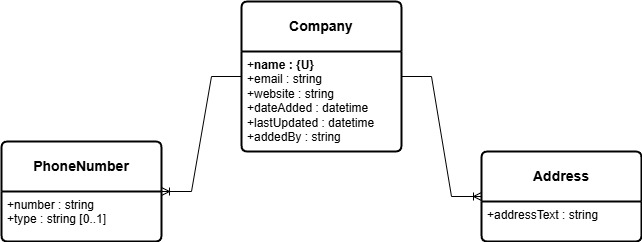

In [3]:
Image('industries_erd_2.jpg')

<br>

### <font color='orange'>Logical-Level</font>

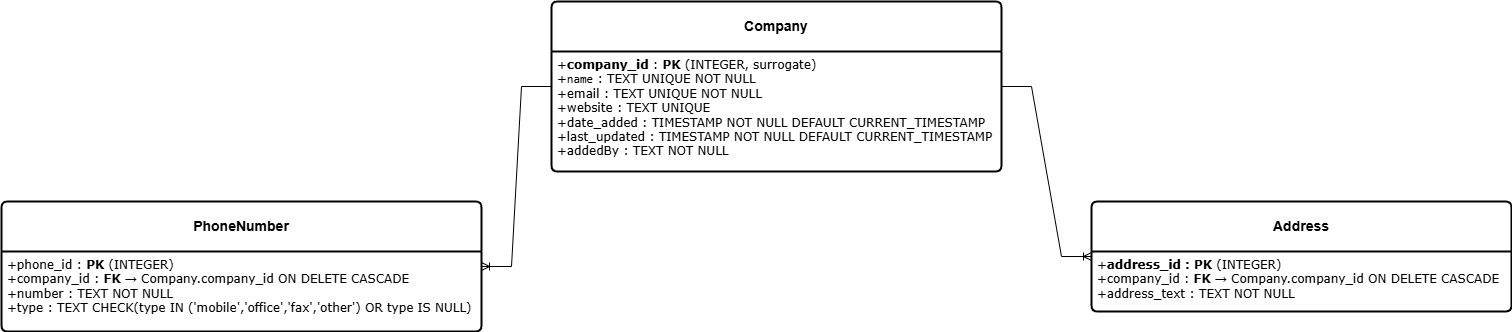

In [4]:
Image('industries_erd_logical.jpg')

<br>

Some notes on the ERD:
- Company:
  - `name` is the natural key, but we add a surrogate company_id to avoid cascading name changes.
  - `email` is mandatory and unique (top contact priority)
  - `website` may be NULL, but if present, must be unique.
- PhoneNumber:
  - Each record belongs to one company; a company may have 0..N phones.
  - Optional single `type` label.
  - (Unique pair) UNIQUE(company_id, number) prevents duplicates for the same company.
- Address:
  - `address_text` is a free-text block per requirement.
  - A company may have 0..N addresses.

## Checking Normalization

- 1NF
  - Each column value must be a single value only (atomic)
  - Repeating groups removal
  - All values in a column must be of the same type
  - Each column name must be unique
  - No two rows in a column can be identical

- 2NF
  - A table meets all 1NF requirements
  - All non-key attributes (fields) are dependent only on the primary key (Note: all single-column tables are automatically in 2NF)


- 3NF
  - A table meets all 2NF requirements
  - Contains No transitive dependencies

<br>
Therefore the design sits cleanly in 3NF; no further decomposition needed.
Let's move on to the physical layer!

<br>

### <font color='lightgreen'>Physical-Level</font>

To implement what theoretically built, we need to form our data appropriately

In [223]:
# basic inspection & whitespace clean up

transformed_data = transformed_data.map(lambda x: x.strip() if isinstance(x, str) else x)

In [200]:
# creating the company table
Company = (transformed_data
           .drop_duplicates(subset='company_name')
           .drop_duplicates(subset=['email'], keep='last')
           .assign(company_id=lambda d: d.index + 1) # 1,2,3… surrogate key
            [['company_id', 'company_name', 'email', 'website']]
           .reset_index(drop=True))

In [202]:
# fill empty phone numbers with nan
filt = transformed_data.phone_number == ''
transformed_data.loc[filt, 'phone_number'] = np.nan

# create the PhoneNumber table
PhoneNumber = (transformed_data[['company_name', 'phone_number']]
               .dropna(subset='phone_number')
               .assign(phone_number=lambda x: x['phone_number'].str.split(','))
               .explode('phone_number')
               .assign(phone=lambda d: d['phone_number'].str.strip())
               .drop('phone_number', axis=1))

PhoneNumber['type'] = None # create new column for phone number type (company, mobile)

PhoneNumber['type'] = PhoneNumber['phone'].apply(lambda x: 'mobile' if str(x).startswith('6') else 'company')

# merging the PhoneNumber table with Company table on company_name to get the company_id
PhoneNumber = PhoneNumber.merge(Company[['company_id', 'company_name']],
                                on='company_name', how='inner')[['company_id', 'phone', 'type']]

# dropping any duplicates
PhoneNumber = PhoneNumber.drop_duplicates(['company_id', 'phone'])

In [203]:
# creating the Address table
Address = (transformed_data[['company_name', 'address']]
           .dropna(subset='address')
           .assign(address=lambda x: x['address'].str.strip()
           .drop_duplicates()))

# getting the company_id by merging with Company table on company_name
Address = Address.merge(Company[['company_id', 'company_name']],
                        on='company_name', how='inner')[['company_id', 'address']]

In [204]:
'''
confirming every phone & address row resolved to a valid company_id

ensuring no duplicates in Company.email and Company.website
'''

assert PhoneNumber['company_id'].notna().all()
assert Address['company_id'].notna().all()

assert Company['email'].is_unique
assert Company['website'].dropna().is_unique

In [219]:
'''
we left in the end before we move on with the database the three missing fields depicting
timestamps and how made the changes
'''

now = datetime.datetime.now()

Company['date_added'] = now
Company['last_updated'] = now
Company['added_by'] = 'george@data_science.project'

# _Load_



In [218]:
# establishing our database
con = sqlite3.connect('company_info.db')
con.execute('PRAGMA foreign_keys = ON;')   # enforce FK rules

In [220]:
# bulk insert
Company.to_sql('Company', con, if_exists='append', index=False)
PhoneNumber.to_sql('PhoneNumber', con, if_exists='append', index=False)
Address.to_sql('Address', con, if_exists='append', index=False)
con.commit()

In [236]:
# quick check if the data have been uploaded to the db correctly

if (pd.read_sql("SELECT COUNT(*) c FROM Company", con)['c'][0] == len(Company)) and \
    (pd.read_sql("SELECT COUNT(*) c FROM PhoneNumber", con)['c'][0] == len(PhoneNumber)):
    print('All Ok')
else:
    print('Something went wrong')

All Ok


In [237]:
# cursor object
cursor = con.cursor()

# query as a text
statement = '''SELECT c.company_name, p.phone, p.type
                FROM Company c
                JOIN PhoneNumber p
                ON c.company_id = p.company_id
                LIMIT(5)'''

cursor.execute(statement)

print('Query Result')
output = cursor.fetchall()
for row in output:
  print(row)

Query Result
('ΠΑΠΑΓΕΩΡΓΙΟΥ WIRELAND ΟΕ', '2310527742', 'company')
('ΠΑΠΑΓΕΩΡΓΙΟΥ WIRELAND ΟΕ', '2310795992', 'company')
('3DHUB IKE', '2104636659', 'company')
('Adamant Composites', '2610931730', 'company')
('ADVANCED ENGINEERING TECHNOLOGIES', '2110176456', 'company')


It looks like it works! Mission accomplished. Everyone is happy 😀. Hooray 🙌

In [238]:
con.close()